## Figure 4. a.

In [ ]:
#TBC

## Figure 4. b.

In [1]:
# Similarity Matrix Patient
Patient = "273"

In [2]:
%reload_ext autoreload
%autoreload 2
#Custom Files
from DataManager import dataManager
from DataManagerUtil import *
import GCN as GCN
import GCNutil as GCNutil
import GDE as GDE
import GDEutil as GDEutil
import GDEsolvers as GDEsolvers
import MLP as MLP
from Full_model import Integrated_Model, Integrated_Model_RNN
import RNN as RNN

#Standard Libraries
# Torch
import torch
import torch.autograd
import torch.nn as nn
import torch.nn.functional as F
#Numpy
import numpy as np

In [3]:
filepath = 'datasets\pat_FR_'+Patient+'.mat' #264 253 620 273
variables = load_patient_data(filepath, verbose = False)
dm = dataManager(variables["X_train"],variables["X_test"],variables["y_train"],variables["y_test"],10**(-4))

--------data manager successfully initialized--------


In [5]:
dm.apply_dvariance_filter(28)
dm.mean_pooling_1d(size = 24, stride = 20, padding = 0)

--------data successfully filtered (dvariance)--------


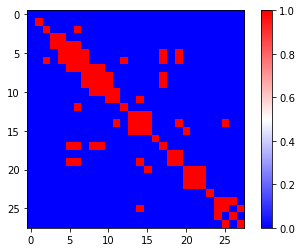

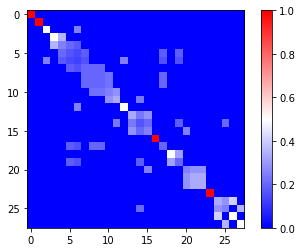

In [6]:
n = 1.3*10**-2
dm.re_threshold(n)
show_heat_map(dm.A_train)
show_heat_map(create_DAD(dm.A_train))
#print(create_DAD(dm.A_train))
Araw =  dm.A_train

In [156]:
GCNparameters = {
    'body': dm.X_train.shape[2],
    'M': dm.X_train.shape[0],
    'batch_size': 256,
    'n_layers': 1,
    'num_epochs': 1,
    'learning_rate': 1e-3,
    'weight_decay': 5e-3
}
GDEparameters = {
    'body': dm.X_train.shape[2],
    'solver': GDEsolvers.explicit_RK,
    'solver_params': {
    "t0": 0,
    "t1": 0.25,
    "N": 5,
    "b_tableau": GDEsolvers.RK4
     },
    'hidden_layers': 1,
    'M': dm.X_train.shape[0],
    'batch_size': 128,
    'num_epochs': 1,
    'learning_rate': 1e-3,
    'weight_decay': 5e-3
}
GCNcheckpoint = {'parameters': GCNparameters}
GDEcheckpoint = {'parameters': GDEparameters}

In [157]:
A = create_DAD(Araw)
device_name = 'cpu'
GCNmodel, GCNcheckpoint = GCNutil.train_GCN(A, dm.X_train, dm.X_test, GCNcheckpoint, device_name = device_name, load = False, print_summary = False)

100%|██████████| 11/11 [00:00<00:00, 62.31it/s]

device set to cpu
Epoch: 1   Batch: 11 of size 256   Train loss: 312.4990539550781   Valid loss: 312.1700744628906


In [158]:
A = create_DAD(Araw)

device_name = 'cpu'
GDEmodel, GDEcheckpoint = GDEutil.train_GDE(A, dm.X_train, dm.X_test, GDEcheckpoint, device_name = device_name, load = False, print_summary = False)

  5%|▍         | 1/21 [00:00<00:02,  7.06it/s]

device set to cpu


 14%|█▍        | 3/21 [00:00<00:02,  6.97it/s]

 24%|██▍       | 5/21 [00:00<00:02,  6.95it/s]

 33%|███▎      | 7/21 [00:01<00:02,  6.96it/s]

 43%|████▎     | 9/21 [00:01<00:01,  6.68it/s]

 52%|█████▏    | 11/21 [00:01<00:01,  6.91it/s]

 62%|██████▏   | 13/21 [00:01<00:01,  6.66it/s]

 71%|███████▏  | 15/21 [00:02<00:00,  6.62it/s]

 81%|████████  | 17/21 [00:02<00:00,  6.64it/s]

 90%|█████████ | 19/21 [00:02<00:00,  6.88it/s]

100%|██████████| 21/21 [00:02<00:00,  7.02it/s]

Epoch: 1   Batch: 21 of size 128   Train loss: 309.80560302734375   Valid loss: 309.2062072753906


In [176]:
def save_heat_map(m, DIR, cmap = 'bwr'):
    plt.clf
    fig = plt.figure()
    plt.imshow(m, cmap=cmap, interpolation='nearest')
    plt.colorbar()
    plt.show()
    plt.savefig(DIR)
    
def save_avg_sim_matrix(dm, sim_test, DIR):
    ictal_sum = np.zeros(sim_test[0][:,:].shape)
    normal_sum = np.zeros(sim_test[0][:,:].shape)
    tc = 0
    ni = 0
    nn = 0
    for i in range(sim_test.shape[0]):
            if dm.Y_test[tc,0] == 1:
                ictal_sum = ictal_sum + sim_test[i,:,:]
                ni+=1
            else:
                normal_sum = normal_sum + sim_test[i,:,:]
                nn+=1
            tc+=1
    ictal_sum = ictal_sum / ni
    normal_sum = normal_sum / nn
    print("Average ictal")
    save_heat_map(ictal_sum, DIR+"ictal")
    print("Average Non-Ictal")
    save_heat_map(normal_sum, DIR+"non-ictal")
    
def save_sequential_plot(dm, sim_test, DIR, i = 0):
    plt.clf
    fig, ax = plt.subplots(nrows=2, ncols=5, constrained_layout=False)
    #plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.1)
    #plt.tight_layout()
    ictal = 0
    non_ictal = 0
    for row in ax:
        for col in row:
            im = col.imshow(sim_test[i], cmap='pink', interpolation='nearest')
            if dm.Y_test[i,0] == 1: 
                ictal+=1
                col.title.set_text("ictal {}".format(ictal))
            else:
                non_ictal += 1
                col.title.set_text("non-ictal {}".format(non_ictal))
            col.axis('off')
            i+=1

    cbar_ax = fig.add_axes([1.1, 0.15, 0.05, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    
    plt.savefig(DIR)
    plt.show()
    

In [160]:
sim_all = {}
A = create_DAD(Araw)
X_train = dm.X_train
X_test = dm.X_test
device_name = 'cpu'
#Get simularity matrix from GCN
GCNmodel.eval()
sim_all["GCN_train"] = GCNmodel(torch.from_numpy(X_train).float().to(device_name), torch.from_numpy(A).float().to(device_name)).cpu().detach().numpy()
sim_all["GCN_test"] = GCNmodel(torch.from_numpy(X_test).float().to(device_name), torch.from_numpy(A).float().to(device_name)).cpu().detach().numpy()
#Get simularity matrix from GNODE
GDEmodel.eval()
sim_all["GDE_train"] = GDEmodel(torch.from_numpy(X_train).float().to(device_name)).cpu().detach().numpy()
sim_all["GDE_test"] = GDEmodel(torch.from_numpy(X_test).float().to(device_name)).cpu().detach().numpy()

Average ictal


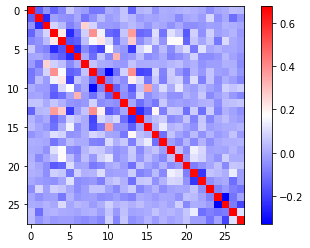

Average Non-Ictal


<Figure size 432x288 with 0 Axes>

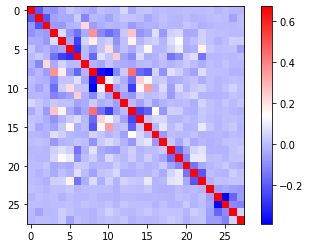

Average ictal


<Figure size 432x288 with 0 Axes>

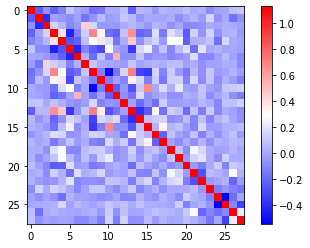

Average Non-Ictal


<Figure size 432x288 with 0 Axes>

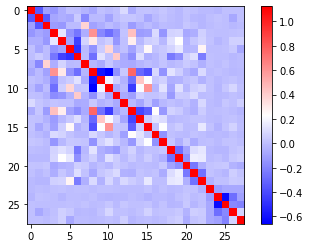

<Figure size 432x288 with 0 Axes>

In [39]:
save_avg_sim_matrix(dm, sim_all["GCN_test"], "Figure 4. b/GCN_2L"+Patient)
save_avg_sim_matrix(dm, sim_all["GDE_test"], "Figure 4. b/GDE_EF"+Patient)

In [117]:
#print(dm.Y_test.tolist())

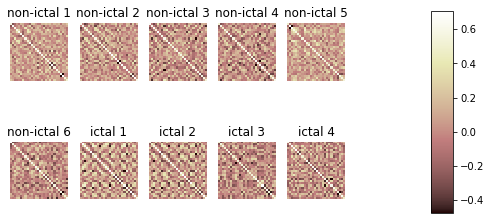

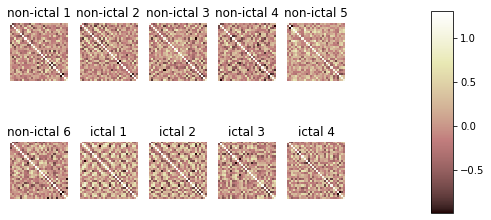

In [177]:
save_sequential_plot(dm, sim_all["GCN_test"], "Figure 4. b/GCN_1L_sequence_"+Patient, i = 15)
save_sequential_plot(dm, sim_all["GDE_test"], "Figure 4. b/GDE_RK4_sequence_"+Patient, i = 15)
#save_heat_map(sim_all["GCN_test"][0], "junk")

## Figure 4. c.

In [ ]:
#Extract Hidden State

## Figure 4. d.